In [68]:
import xarray as xr
import cartopy.crs as ccrs

import math
import numpy as np

import matplotlib.pyplot as plt

import torch

<xarray.DataArray 'time' (time: 720)>
array([cftime.Datetime360Day(2080, 2, 1, 0, 30, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2080, 2, 1, 1, 30, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2080, 2, 1, 2, 30, 0, 0, has_year_zero=True), ...,
       cftime.Datetime360Day(2080, 2, 30, 21, 30, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2080, 2, 30, 22, 30, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2080, 2, 30, 23, 30, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time          (time) object 2080-02-01 00:30:00 ... 2080-02-30 23:30:00
    month_number  (time) int32 ...
    year          (time) int32 ...
    yyyymmddhh    (time) |S64 ...
Attributes:
    axis:           T
    bounds:         time_bnds
    standard_name:  time

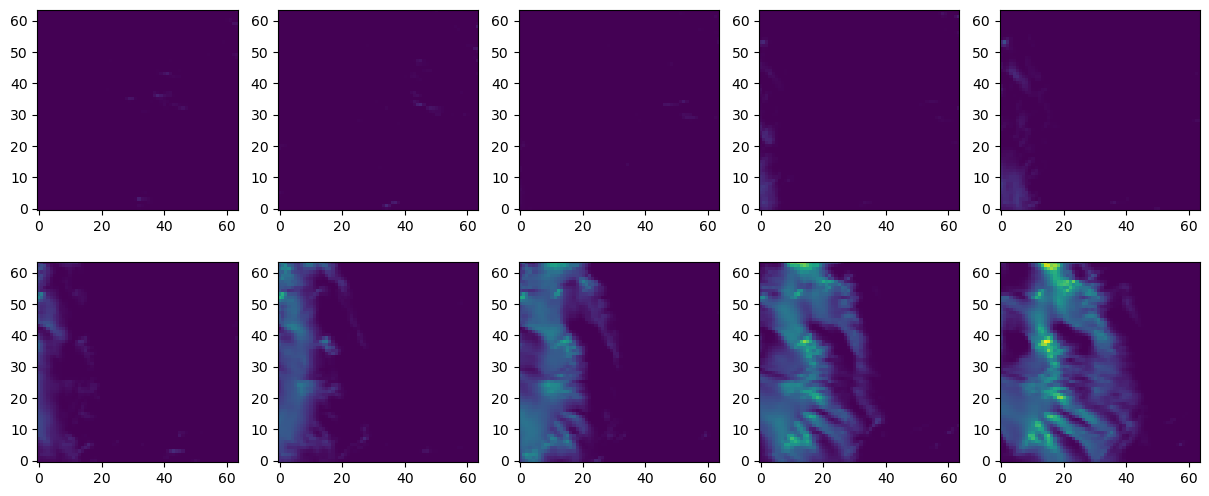

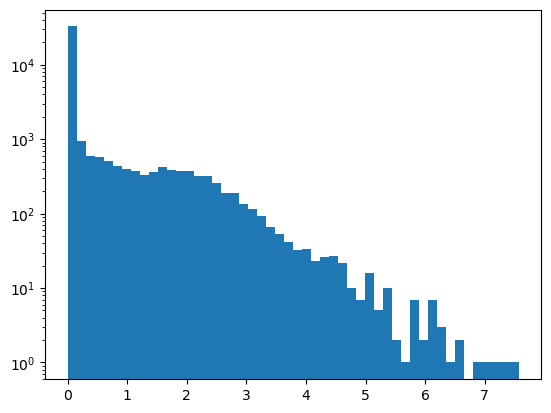

min: 0.0, max: 7.567968368530273, mean: 0.29529401659965515


In [6]:
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_19801201-19801230.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20660501-20660530.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20801101-20801130.nc")

ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20800201-20800230.nc")
display(ds.time)
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20800301-20800330.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20800401-20800430.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20800501-20800530.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20800601-20800630.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20800701-20800730.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20800801-20800830.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20800901-20800930.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20801001-20801030.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20801101-20801130.nc")

index = 710
pr = ds.isel(time = slice(index, index + 10)).pr.values[0]

fig, axs = plt.subplots(2, 5, figsize = (15, 6))
for i in range(10):
    ax = axs.flat[i]
    frame = pr[i]
    ax.imshow(frame, origin = "lower", vmin = pr.min(), vmax = pr.max())
plt.show()

plt.hist(pr.flatten(), bins = 50)
plt.yscale("log")
plt.show()

print(f"min: {pr.min()}, max: {pr.max()}, mean: {pr.mean()}")

tensor(4.2422)

Example 0:
min: 0.03420965373516083, max: 14.658117294311523
mean: 4.197768211364746
torch.Size([10, 64, 64])


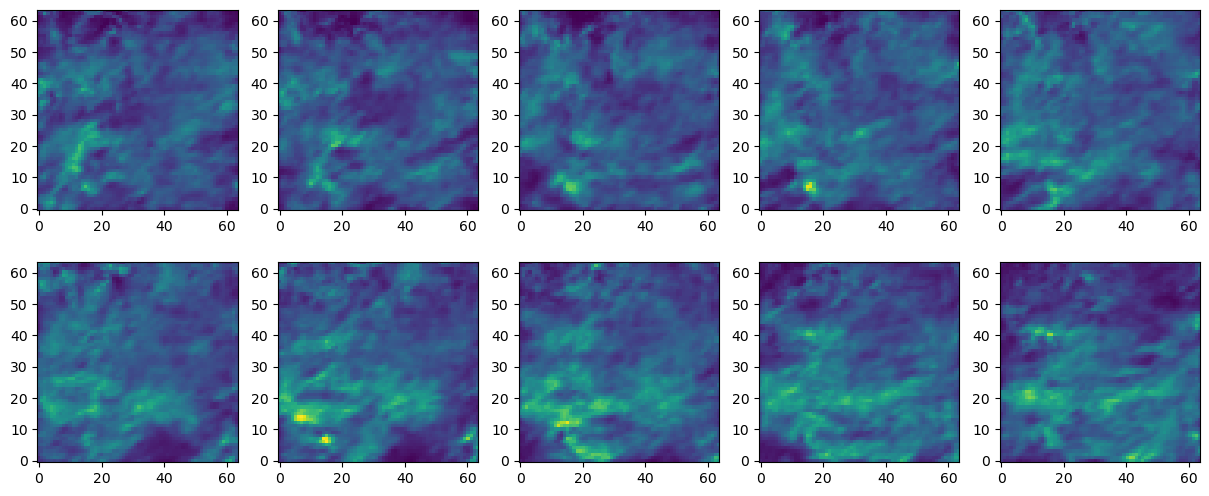

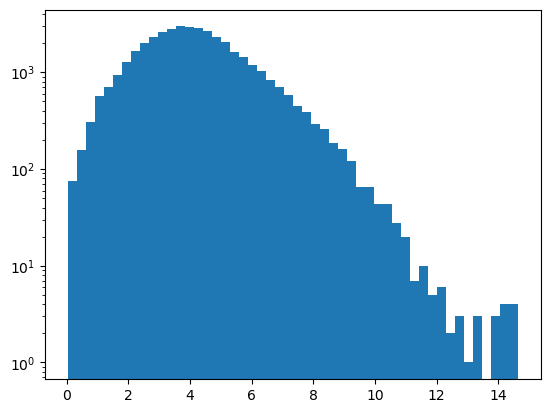


Example 1:
min: 0.00560950580984354, max: 10.135780334472656
mean: 1.6648727655410767
torch.Size([10, 64, 64])


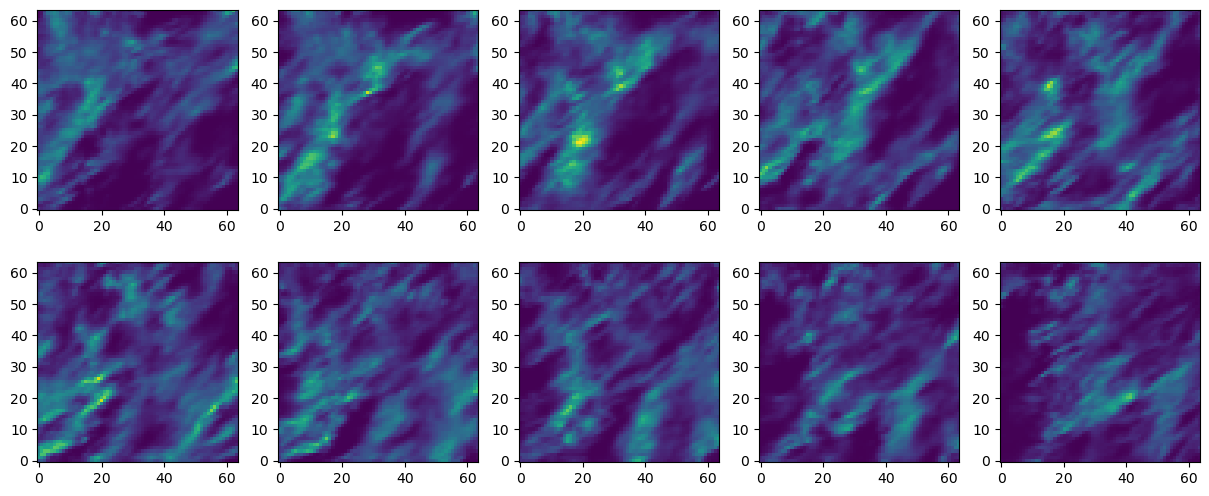

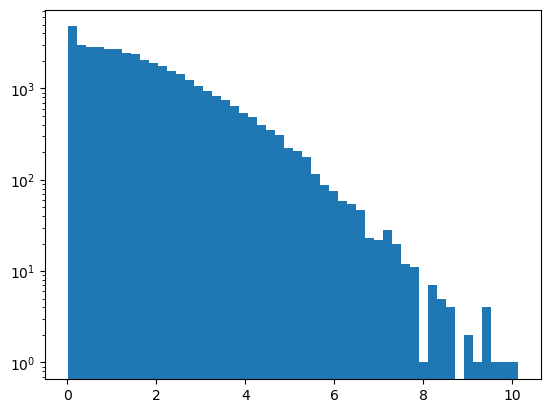


Example 2:
min: 0.08709196001291275, max: 10.146222114562988
mean: 3.335714340209961
torch.Size([10, 64, 64])


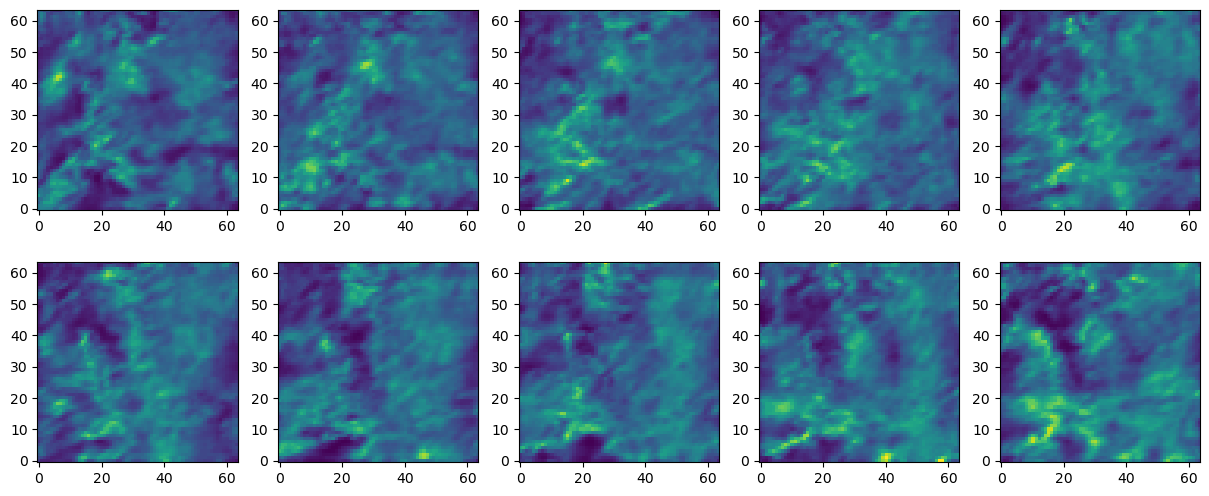

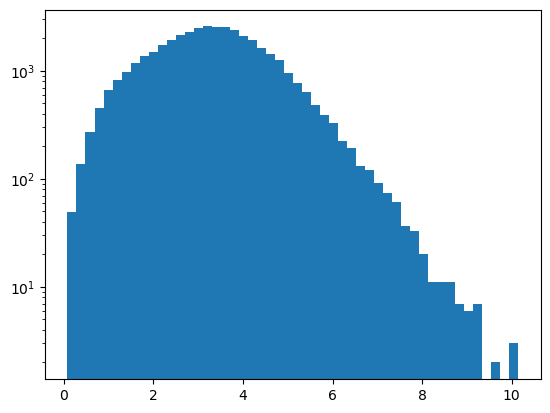


Example 3:
min: 0.0, max: 10.523065567016602
mean: 0.3682229518890381
torch.Size([10, 64, 64])


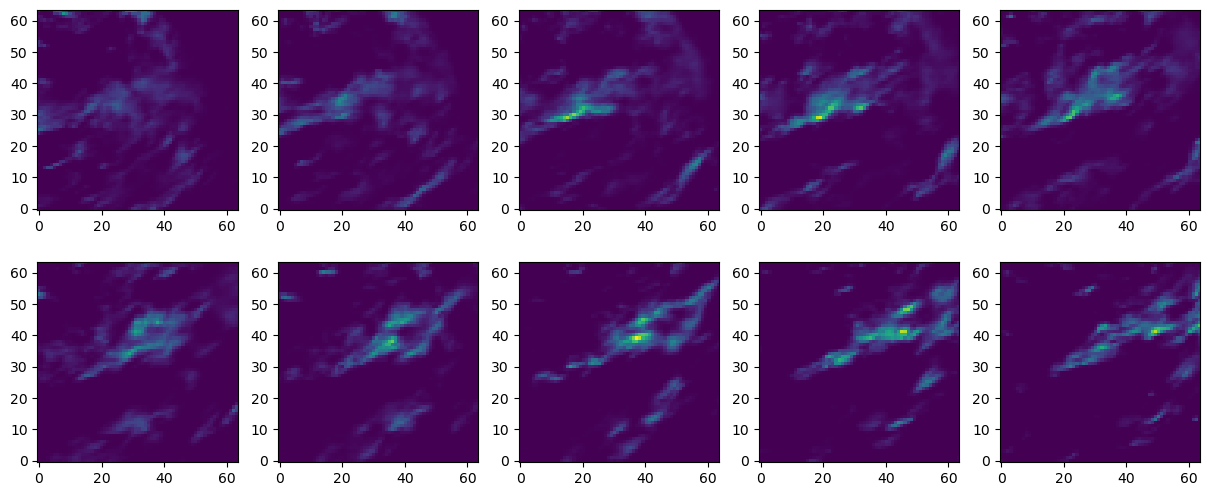

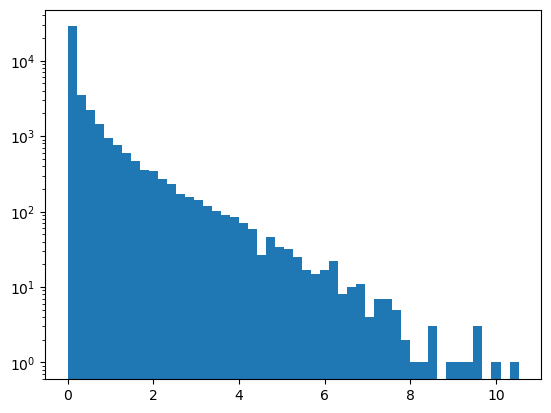


Example 4:
min: 0.0019567832350730896, max: 3.6487324237823486
mean: 0.13398738205432892
torch.Size([10, 64, 64])


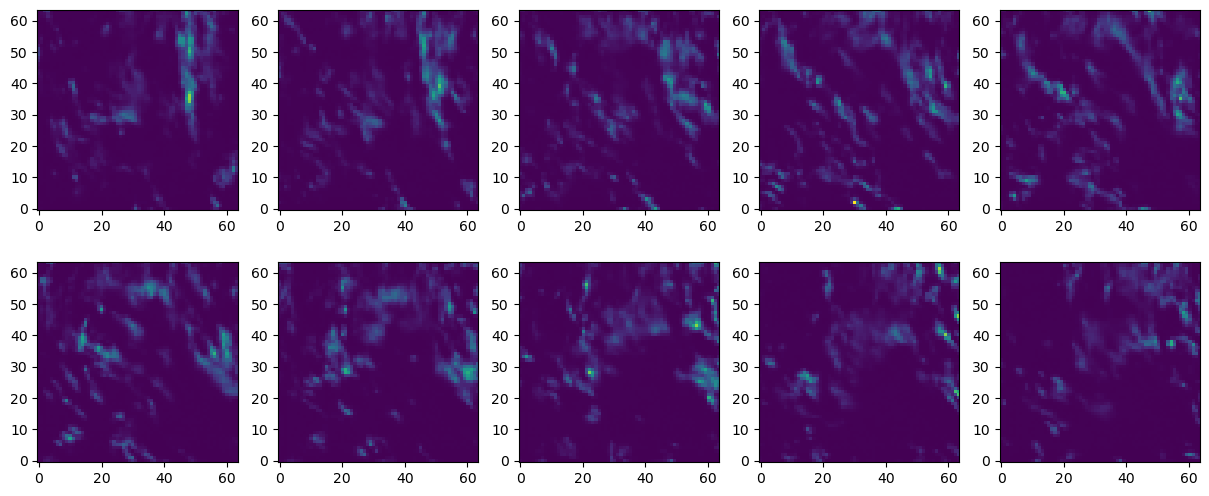

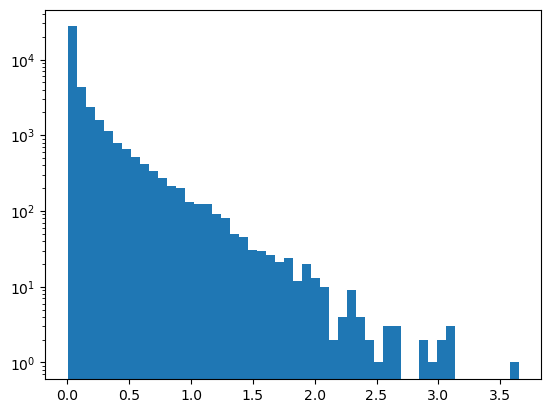


Example 5:
min: 0.04259664937853813, max: 11.129655838012695
mean: 3.3885886669158936
torch.Size([10, 64, 64])


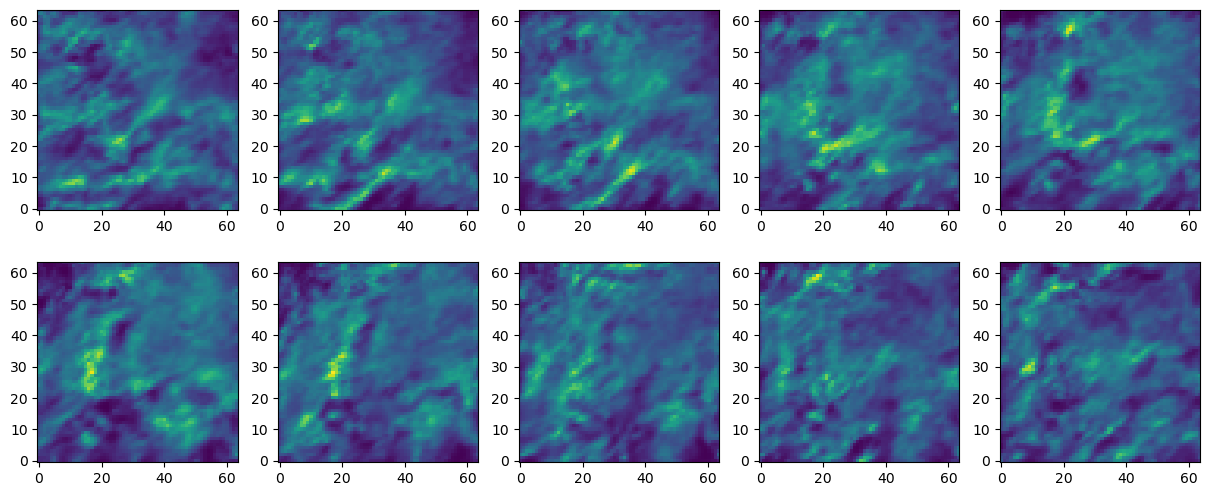

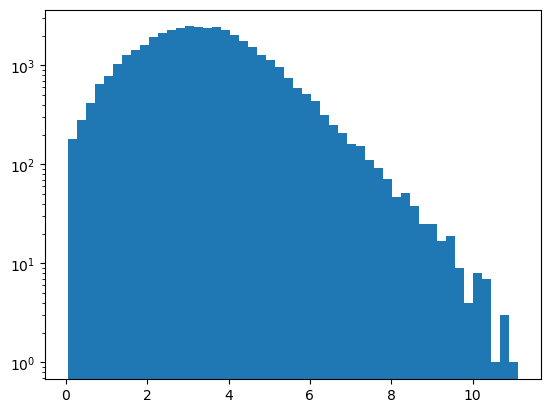


Example 6:
min: 0.010906399227678776, max: 11.965495109558105
mean: 2.070939064025879
torch.Size([10, 64, 64])


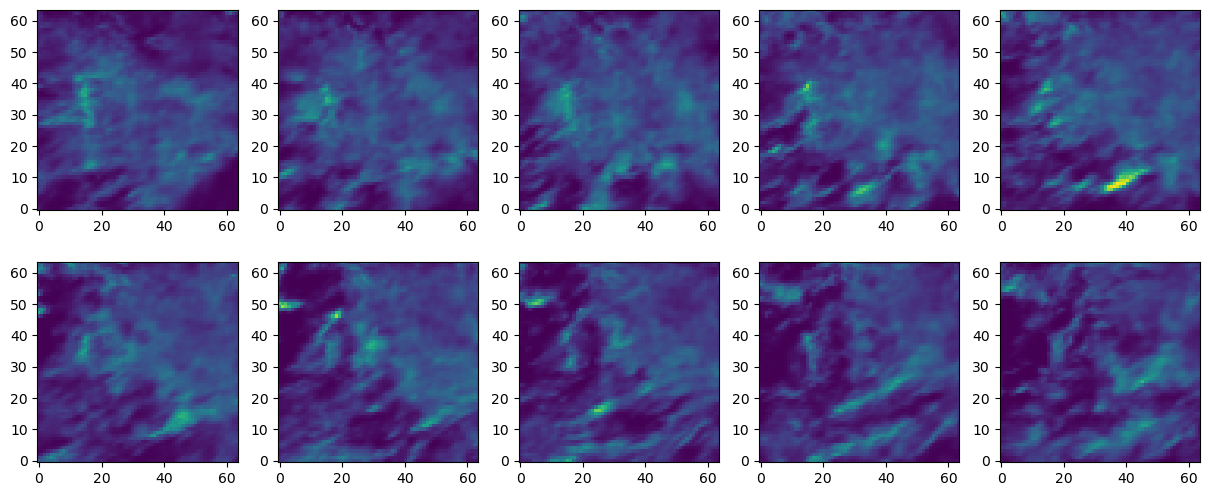

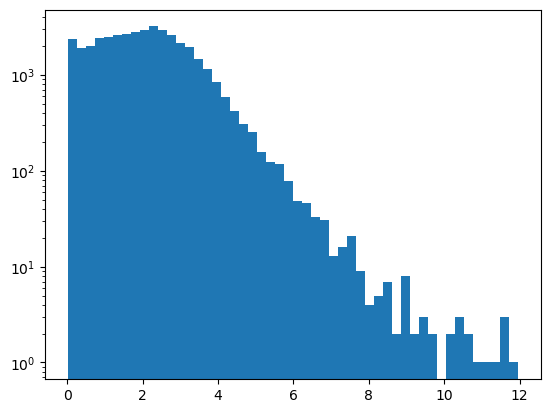


Example 7:
min: 0.010932846926152706, max: 13.05845832824707
mean: 1.7724237442016602
torch.Size([10, 64, 64])


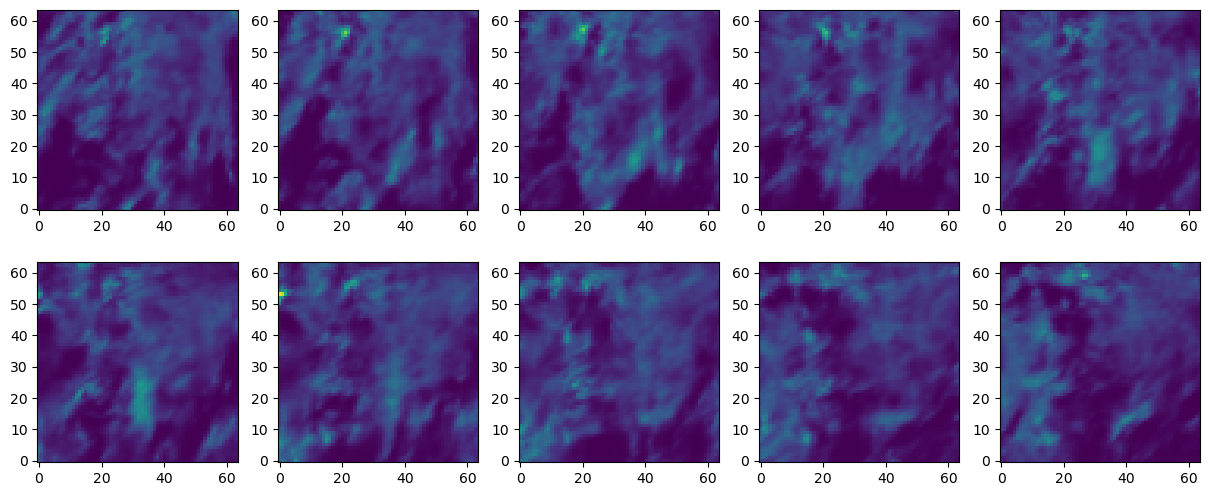

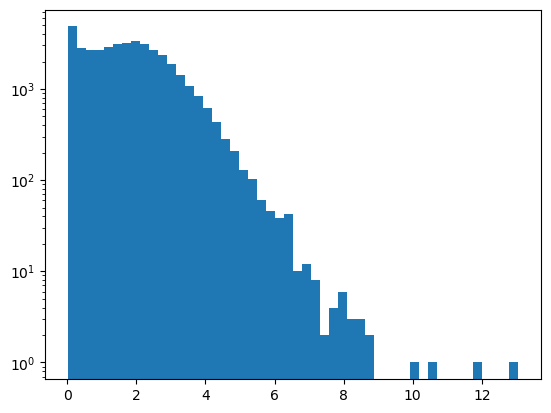


Example 8:
min: 0.21023833751678467, max: 13.07699203491211
mean: 4.327092170715332
torch.Size([10, 64, 64])


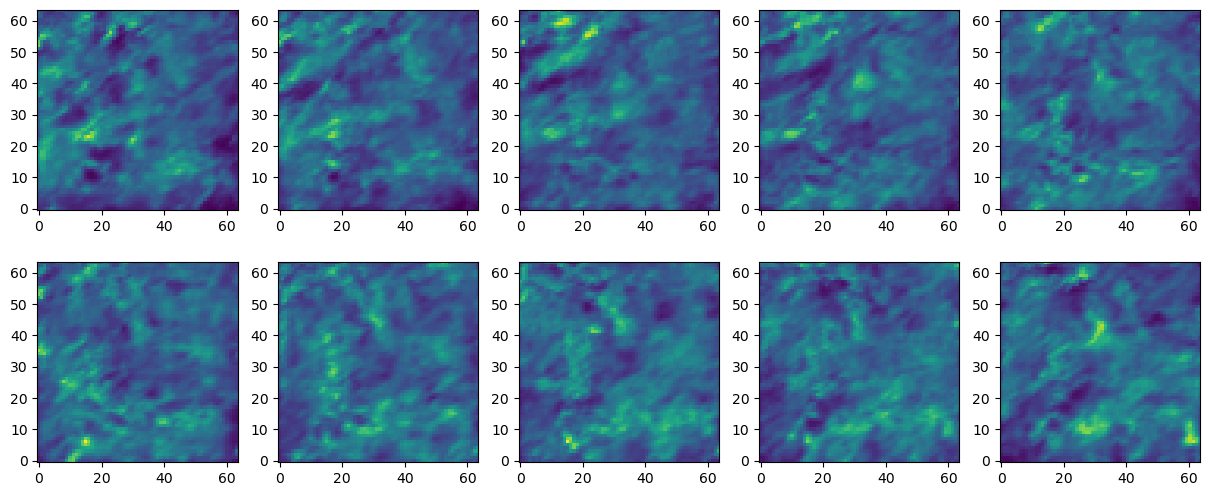

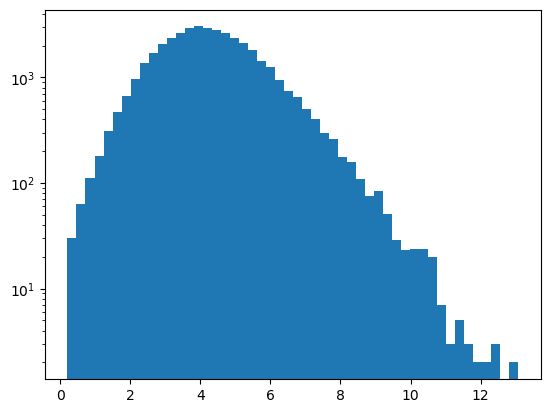


Example 9:
min: 0.0020648965146392584, max: 8.990981101989746
mean: 0.857852578163147
torch.Size([10, 64, 64])


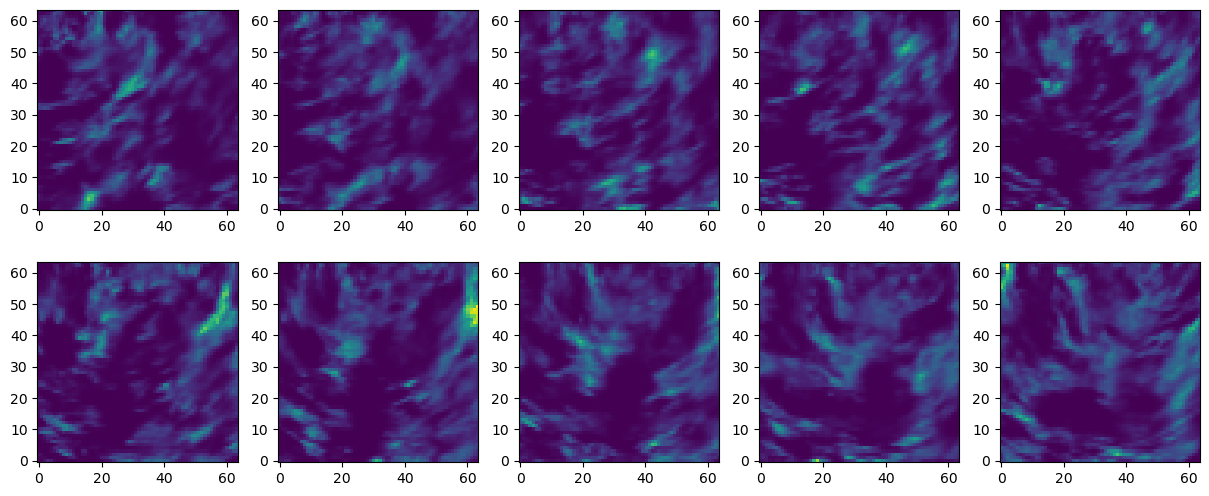

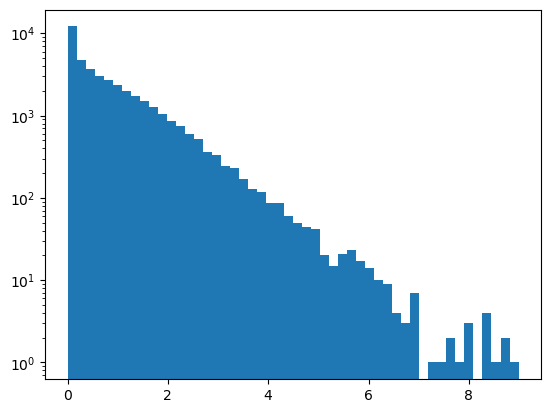

In [95]:
# ds = torch.load("results/results_2r/70.pt", map_location=torch.device('cpu'))
# ds = torch.load("results/results_2r_l2/78.pt", map_location=torch.device('cpu'))
# ds = torch.load("78.pt", map_location=torch.device('cpu'))
# ds = torch.load("samples.pt", map_location=torch.device('cpu'))

ds = torch.load("results/9.pt", map_location=torch.device('cpu'))
print(ds.mean())

for i in range(10):
    ex = ds[i][0]
    print(f"\nExample {i}:")
    print(f"min: {ex.min()}, max: {ex.max()}\nmean: {ex.mean()}")
    print(ex.shape)
    fig, axs = plt.subplots(2, 5, figsize = (15, 6))
    for j in range(10):
        ax = axs.flat[j]
        frame = ex[j]
        ax.imshow(frame, origin = "lower", vmin = ex.min(), vmax = ex.max())
    plt.show()

    plt.hist(ex.flatten(), bins = 50)
    plt.yscale("log")
    plt.show()